In [1]:
%matplotlib inline

import os
import warnings
from copy import deepcopy

import numpy as np

from tvb_epilepsy.base.h5_model import convert_to_h5_model, read_h5_model


/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Configurations
HOME_FOLDER="/Users/dionperd/CBR/VEP"
HYPOTHESIS_NAME = "clinical_hypothesis_new"
FOLDER_VEP = os.path.join(HOME_FOLDER, "CC/TVB2/tvbHead")
PATIENT_VIRTUAL_HEAD = os.path.join(FOLDER_VEP, "Head")
HYPOTHESIS_FOLDER = os.path.join(FOLDER_VEP, HYPOTHESIS_NAME)
RESULTS_FOLDER = os.path.join(HYPOTHESIS_FOLDER, "results")
FOLDER_RES = os.path.join(RESULTS_FOLDER, "data")
FOLDER_FIGURES = os.path.join(RESULTS_FOLDER, "figs")
FOLDER_LOGS = os.path.join(RESULTS_FOLDER, "logs")
SHOW_FLAG = True
SAVE_FLAG = True
FIG_FORMAT = "png"

In [3]:
# Initialize logger
from tvb_epilepsy.base.utils import initialize_logger
logger = initialize_logger(__name__, target_folder=FOLDER_LOGS)

/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute fk_algorithm from non-mapped class WorkflowStepView
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute fk_workflow from non-mapped class WorkflowStepView
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute fk_algorithm from non-mapped class WorkflowStep
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute fk_workflow from non-mapped class WorkflowStep
  (desc.fget

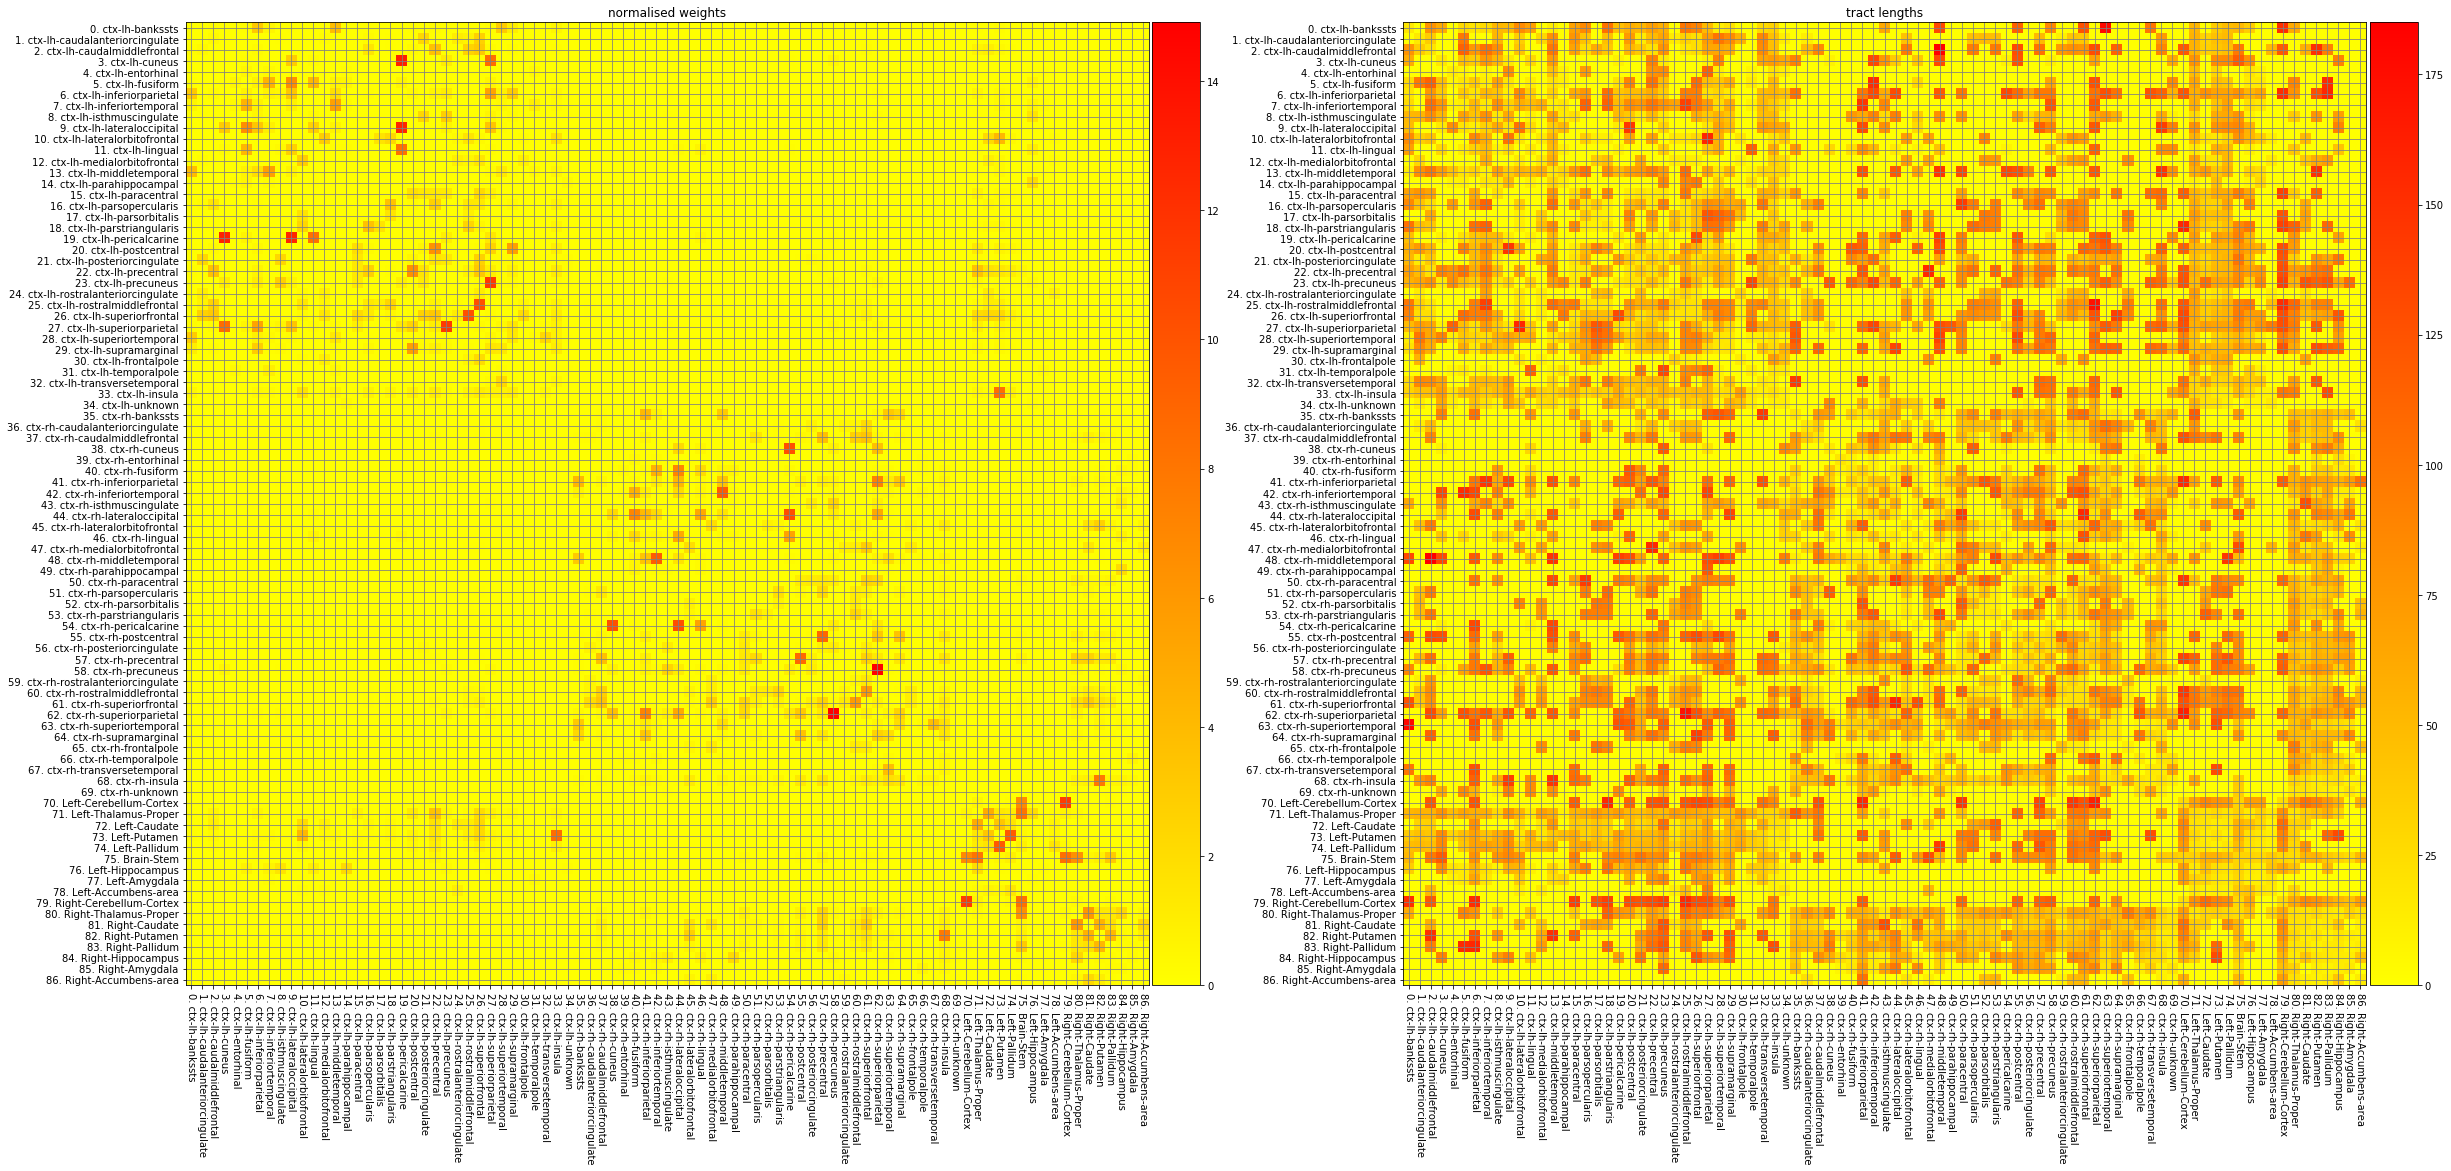

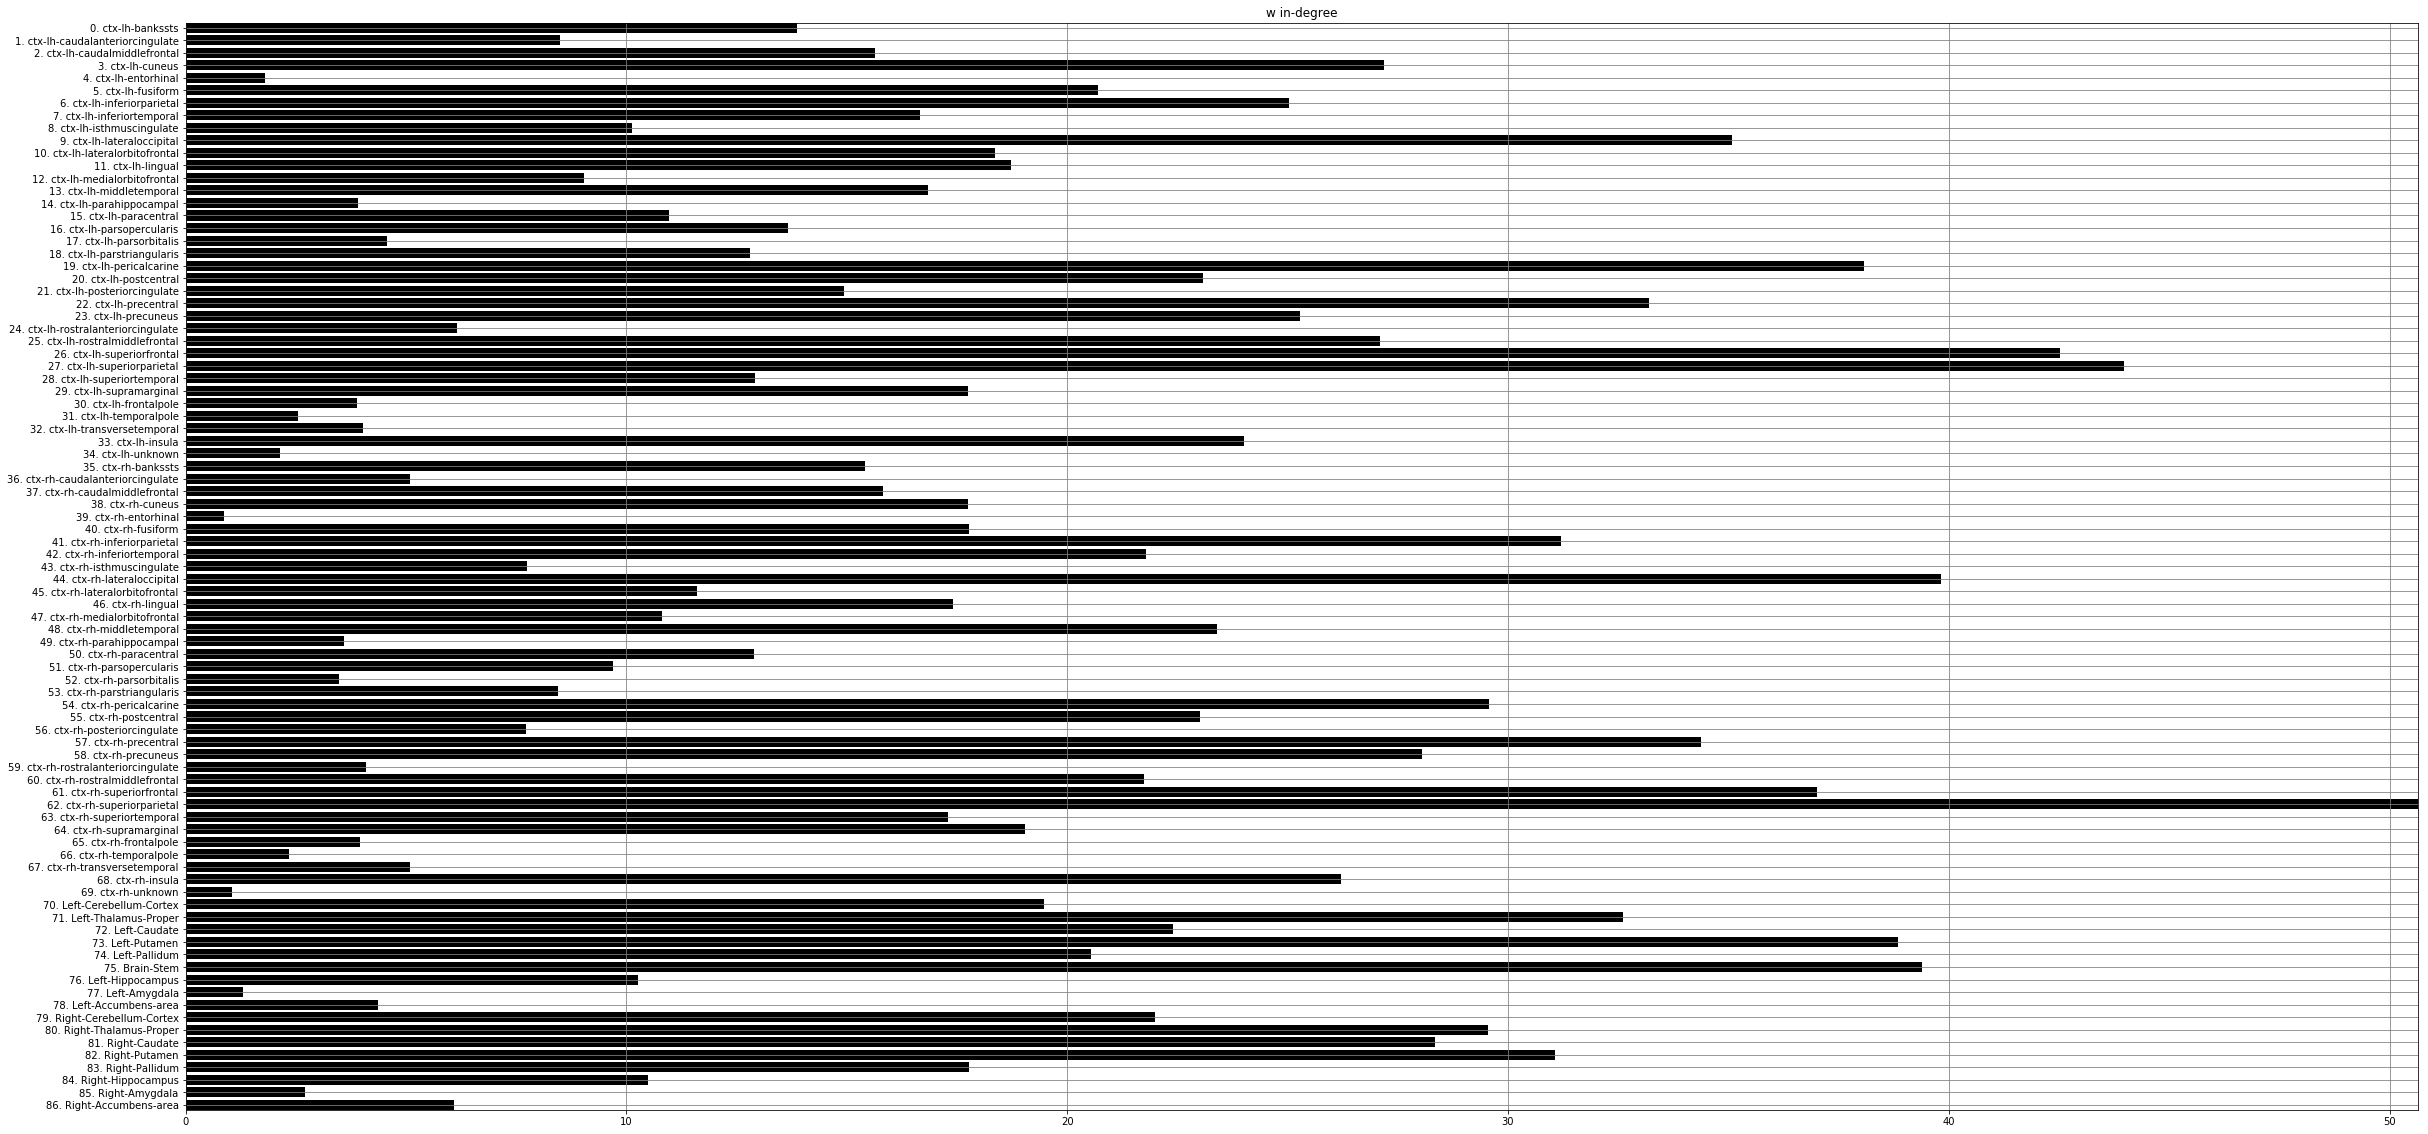

In [4]:
# Reading data

# from tvb_epilepsy.tvb_api.readers_tvb import TVBReader as Reader
# reader = Reader()
# logger.info("Reading from: " + FOLDER_VEP)
# head = reader.read_head(FOLDER_VEP, connectivity_file="tvb_connectivity.zip")

from tvb_epilepsy.custom.readers_custom import CustomReader as Reader

reader = Reader()
logger.info("Reading from: " + PATIENT_VIRTUAL_HEAD)
head = reader.read_head(PATIENT_VIRTUAL_HEAD)

# Plot
# print str(head)
head.plot(show_flag=SHOW_FLAG, save_flag=SAVE_FLAG, figure_dir=FOLDER_FIGURES, figure_format=FIG_FORMAT)

In [7]:
#...and defining a VEP hypothesis
from tvb_epilepsy.base.model.disease_hypothesis import DiseaseHypothesis

# Regions of Pathological Excitability hypothesis 
# (value range: x0_values = [0.0, 1.0] corresponding to x0 = [2.460, -2.062]
# by calculating: x0 = 0.398 * x0_values - 2.460
# In the absence of any connectivity, x0cr = -2.062 is the critical value (and therefore x0_values_cr = 1.0)
# When some connectivity is present, x0cr > -2.062 (and therefore x0_values_cr < 1.0)
# This relationship between x0 and the scaled x0_values changes if any of the parameters yc, Iext1, a, b, d of the
# epileptor change, to conserve x0values_cr <= 1.0
x0_indices = []
x0_values = []

# Regions of Model Epileptogenicity hypothesis:
# (value range: E = [0.0, 1.0] corresponding to x1 equilibrium point 
# x1eq = [-5/3, -4/3], where x1eq* = -4/3 is the bifurcation point):
e_indices = [2, 32]
e_values = [0.8, 0.9]

# Global/afferent coupling hypothesis:
# (value range: K = [0.0, ??); it will be scaled in the background by the number of regions)
K_indices = [] # Set region indices for afferent coupling, else it propagates to all regions (i.e., global coupling)
K_values = [10.0]

# Regions of Connectivity hypothesis:
# connectivity will be scaled multiplicatively 
# (i.e, w_disease[w_indices]  = w_original[w_indices] * w_values)
w_indices = [] # linear indice
w_values = [] 

disease_indices = np.unique(x0_indices + e_indices)

hyp = DiseaseHypothesis(head.connectivity.number_of_regions, 
                        excitability_hypothesis={}, 
                        epileptogenicity_hypothesis={tuple(e_indices): e_values},
                        connectivity_hypothesis={})

logger.info("\n\nRunning hypothesis: " + hyp.name)

In [6]:
# Model configuration
from tvb_epilepsy.service.model_configuration_service import ModelConfigurationService

logger.info("\n\nCreating model configuration...")
if len(K_values) == 0:
    model_configuration_service = ModelConfigurationService(hyp.number_of_regions)
else:
    from tvb_epilepsy.base.constants import K_DEF
    if len(K_indices) == 0:
        model_configuration_service = ModelConfigurationService(hyp.number_of_regions, K=K_values[0])
    else:
        K = K_DEF * numpy.ones((hyp.number_of_regions,), dtype=numpy.float32)
        K[K_indices] = K_values
        model_configuration_service = ModelConfigurationService(hyp.number_of_regions, K=K)
        
model_configuration_service.write_to_h5(FOLDER_RES, hyp.name + "_model_config_service.h5")

model_configuration = model_configuration_service.configure_model_from_hypothesis(hyp, head.connectivity.normalized_weights)
model_configuration.write_to_h5(FOLDER_RES, hyp.name + "_ModelConfig.h5")

# Plot nullclines and equilibria of model configuration
model_configuration_service.plot_nullclines_eq(model_configuration, head.connectivity.region_labels,
                                               special_idx=disease_indices, model="6d", zmode="lin",
                                               figure_name=hyp.name + "_Nullclines and equilibria")



File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/clinical_hypothesis_new/results/data/Epileptogenicity_Hypothesis_model_config_service.h5 already exists. Enter a different name or press enter to overwrite file: 


File /Users/dionperd/CBR/VEP/CC/TVB2/tvbHead/clinical_hypothesis_new/results/data/Epileptogenicity_Hypothesis_ModelConfig.h5 already exists. Enter a different name or press enter to overwrite file: 


/Users/dionperd/CBR/software/git/tvb-epilepsy/tvb_epilepsy/service/model_configuration_service.py:272: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.axes.hold(True)


In [ ]:
# Simulation: the quick way using my own simulation scripts, 
# with my own -TVB configuration- choices for noise, monitors, parameter values etc
# You can write you own scripts and add them to the repo
from tvb_epilepsy.base.constants import VOIS
from tvb_epilepsy.scripts.simulation_scripts import set_time_scales, setup_TVB_simulation_from_model_configuration
from tvb_epilepsy.scripts.simulation_scripts import prepare_vois_ts_dict, compute_seeg_and_write_ts_h5_file
from tvb_epilepsy.base.plot_utils import plot_sim_results

# Choose model
# Available models beyond the TVB Epileptor (they all encompass optional variations from the different papers):
# EpileptorDP: similar to the TVB Epileptor + optional variations,
# EpileptorDP2D: reduced 2D model, following Proix et all 2014 +optional variations, 
# EpleptorDPrealistic: starting from the TVB Epileptor + optional variations, but:
#      -x0, Iext1, Iext2, slope and K become noisy state variables, 
#      -Iext2 and slope are coupled to z, g, or z*g in order for spikes to appear before seizure,
#      -multiplicative correlated noise is also used
# Optional variations:
zmode="lin" # by default, or "sig" for the sigmoidal expression for the slow z variable in Proix et al. 2014
pmode = "z" # by default, "g" or "z*g" for the feedback coupling to Iext2 and slope for EpileptorDPrealistic

model_name = "Epileptor" 

if model_name is "EpileptorDP2D":
    spectral_raster_plot = False # time-frequency plot
    trajectories_plot = True # x1-z trajectories' plot
else:
    spectral_raster_plot = "lfp"
    trajectories_plot = False

# We don't want any time delays for the moment
head.connectivity.tract_lengths *= 0.0

logger.info("\n\nConfiguring simulation...")

# Configuring time scales of the simulation
fs = 2048.0 # this is the simulation sampling rate that is necessary for the simulation to be stable
time_length = 120000.0  # in msecs, the final output nominal time length of the simulation
report_every_n_monitor_steps = 100.0
# The TVB average monitor will return a sampling frequency of fsAVG=256 Hz by default
(dt, fsAVG, sim_length, monitor_period, n_report_blocks) = set_time_scales(fs=fs, time_length=time_length, 
                                                                           scale_fsavg=None,
                                                                           report_every_n_monitor_steps=
                                                                           report_every_n_monitor_steps)

# This has to run for every different simulation on a different hypothesis/model configuration:
sim = setup_TVB_simulation_from_model_configuration(model_configuration, head.connectivity, dt, 
                                                    sim_length, monitor_period, model_name, zmode=np.array(zmode),
                                                    pmode=np.array(pmode),
                                                    noise_instance=None, noise_intensity=None,
                                                    monitor_expressions=None)

# Integrator and initial conditions initialization. 
# By default initial condition is set right on the equilibrium point.
sim.config_simulation(initial_conditions=None)

logger.info("\n\nSimulating...")
ttavg, tavg_data, status = sim.launch_simulation(n_report_blocks)

# Write settings to a file for future use
convert_to_h5_model(sim.simulation_settings).write_to_h5(FOLDER_RES, hyp.name + "_sim_settings.h5")
            
if not status:
    warnings.warn("\nSimulation failed!")

else:

    time = np.array(ttavg, dtype='float32')
    
    output_sampling_time = np.mean(np.diff(time))
    tavg_data = tavg_data[:, :, :, 0]

    logger.info("\n\nSimulated signal return shape: %s", tavg_data.shape)
    logger.info("Time: %s - %s", time[0], time[-1])
    logger.info("Values: %s - %s", tavg_data.min(), tavg_data.max())

    # Variables of interest in a dictionary:
    vois_ts_dict = prepare_vois_ts_dict(VOIS[model_name], tavg_data)
    vois_ts_dict['time'] = time
    vois_ts_dict['time_units'] = 'msec'

    compute_seeg_and_write_ts_h5_file(FOLDER_RES, hyp.name + "_ts.h5", sim.model, vois_ts_dict,
                                output_sampling_time, time_length, 
                                hpf_flag=True, hpf_low=10.0, hpf_high=256.0, sensor_dicts_list=[head.sensorsSEEG])

    # Plot results
    plot_sim_results(sim.model, disease_indices, hyp.name, head, vois_ts_dict, head.sensorsSEEG.keys(), hpf_flag=True, 
                     trajectories_plot=trajectories_plot, spectral_raster_plot=spectral_raster_plot, log_scale=False,
                     show_flag=SHOW_FLAG, save_flag=SAVE_FLAG)

    # Optionally save results in mat files
    # from scipy.io import savemat
    # savemat(os.path.join(FOLDER_RES, hyp.name + "_ts.mat"), vois_ts_dict)

/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Volume
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Connectivity
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Sensors
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class Surface
  (desc.fget.__name__, cls.__n

...0.0162760416667% done in 0.0885579586029 secs

/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class SpatialPattern
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class SpatioTemporalPattern
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class StimuliRegion
  (desc.fget.__name__, cls.__name__))
/Users/dionperd/anaconda/anaconda/envs/python2_7/lib/python2.7/site-packages/sqlalchemy/ext/declarative/api.py:173: SAWarning: Unmanaged access of declarative attribute __tablename__ from non-mapped class StimuliSurface


...20.0846354167% done in 60.5820410252 secs